In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pygsp
from pygsp import graphs, filters
import networkx as nx
import pickle

In [3]:
Gnx = nx.read_gpickle('graph.gpickle')

In [4]:
len(Gnx.nodes), len(Gnx.edges)

(500, 5675)

In [5]:
#I don't know what I'm doing but it worksThis is the views for the day before and day of stanlee's death
with open('views.pkl', 'rb') as f:
     views_Gnx = pickle.load(f)

In [6]:
#building the quotient signal
views_graph = {}
for node in Gnx.nodes():
    if node in views_Gnx.keys():
        try:
            views_graph[node] = views_Gnx[node][1][0] /  views_Gnx[node][0][0] 
        except IndexError:
            views_graph[node] = views_Gnx[node][0][0]
        except ZeroDivisionError: 
            views_graph[node] = views_Gnx[node][1][0]
        
    else:
        views_graph[node] = 0

In [7]:
views_graph

{'Stan Lee': 347.05108962332224,
 'Dan Goodwin': 1.0267857142857142,
 'What If (comics)': 2.9926470588235294,
 "Comics Buyer's Guide": 1.951219512195122,
 'Robert Bernstein (comics)': 2.75,
 'Horror comics': 1.6444444444444444,
 'Disney Legends': 3.4656964656964657,
 'French New Wave': 1.58560794044665,
 'Marvel Cinematic Universe': 1.7190170940170941,
 'Larry Lieber': 113.61176470588235,
 'Atlas Comics (1950s)': 12.186046511627907,
 'Google Books': 1.346420323325635,
 'Marvel Comics#Editors-in-chief': 0,
 'Don Heck': 58.83,
 'Joe Kubert': 5.607142857142857,
 'Carnegie Hall': 0.9096126255380201,
 'Hank Pym': 1.3726647000983285,
 'Secret Files and Origins': 5.375,
 'Marvel Legends': 1.135048231511254,
 'action figure': 0,
 'Archie Goodwin (comics)': 3.23728813559322,
 'Epic Illustrated': 5.833333333333333,
 'The A.V. Club': 0.9621749408983451,
 'United States Army': 1.0833718600708893,
 'George W. Bush': 2.343924431086303,
 'executive producer': 0,
 'Marie Wilson (American actress)': 2.

In [8]:
isinstance(views_graph,dict)

True

In [9]:
nodes = np.array(Gnx.nodes())
nx.set_node_attributes(Gnx, values=views_graph, name= 'quotient')
quotient = nx.get_node_attributes(Gnx, 'quotient')
signal = np.array([quotient[n] for n in nodes])

In [10]:
Gnx.node['Stan Lee']

{'quotient': 347.05108962332224}

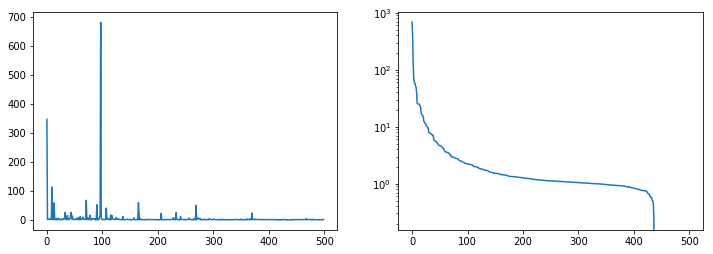

In [11]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(signal)
plt.subplot(1,2,2)
plt.semilogy(sorted(signal, reverse=True))

In [12]:
# look at what pages got the highest delta
list(zip(nodes[signal>20],signal[signal>20]))

[('Stan Lee', 347.05108962332224),
 ('Larry Lieber', 113.61176470588235),
 ('Don Heck', 58.83),
 ('Joe Simon', 25.946428571428573),
 ('Dick Ayers', 25.142857142857142),
 ('DC Comics Presents', 25.19672131147541),
 ('Just Imagine...', 67.58095238095238),
 ('Steve Ditko', 52.28125),
 ('Joe Maneely', 682.1666666666666),
 ('Cedars-Sinai Medical Center', 40.795698924731184),
 ('Jack Kirby', 59.86119402985074),
 ('Iron Man', 24.72867298578199),
 ('Polygon (website)', 22.4568345323741),
 ('Ringo Kid', 25.0),
 ('John Romita Sr.', 49.97126436781609),
 ('Comics Code Authority', 23.620192307692307)]

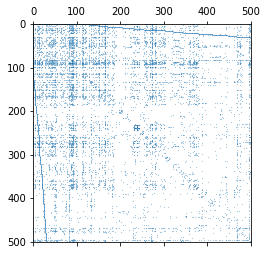

In [13]:
# make graph undirected & remove self loops
A = nx.adjacency_matrix(Gnx).todense()
A = np.logical_or(A, A.T).astype(int)
np.fill_diagonal(A, 0)
A = np.array(A)
adjacency = sparse.csr_matrix(A)

plt.spy(adjacency, markersize=0.1)

In [14]:
#sparse.csr_matrix(A)
n_nodes = A.shape[0]
D = sparse.diags(np.sum(A, axis=0))
D_inv_sq = sparse.diags(1 / np.sqrt(np.sum(A,axis=0)))
laplacian_combinatorial = D - adjacency
laplacian_normalized = sparse.eye(n_nodes) - D_inv_sq @ adjacency @ D_inv_sq.T

In [15]:
#eig_val, U = np.linalg.eigh(laplacian_normalized)
eig_val, U = sparse.linalg.eigsh(laplacian_normalized, k=20, which='SM')
U_norm = D_inv_sq @ U # renormalize for eigenmap visualizatio
eigenmap = U[:,1:3]

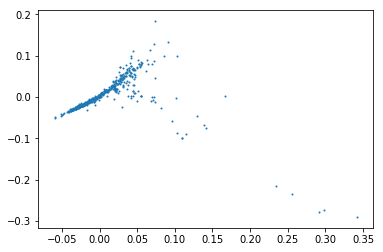

In [16]:
plt.scatter(U[:, 1], U[:, 2], s=1)

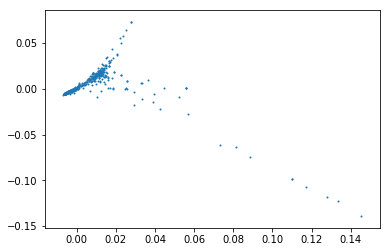

In [17]:
plt.scatter(U_norm[:, 1], U_norm[:, 2], s=1)

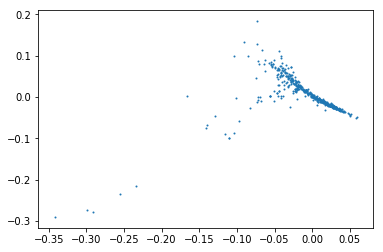

In [18]:
#G = pygsp.graphs.Graph(adjacency, lap_type='combinatorial')
G = pygsp.graphs.Graph(sparse.csr_matrix(A), lap_type='normalized')
eig_val, U = sparse.linalg.eigsh(G.L, k=20, which='SM')
plt.scatter(U[:, 1], U[:, 2], s=1)

In [19]:
#G.set_coordinates(kind='spring')
G.set_coordinates(U[:,1:3])

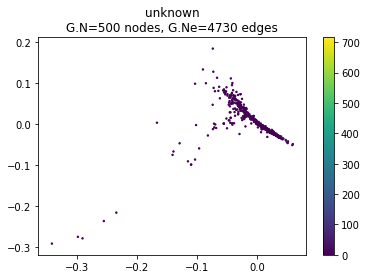

In [20]:
G.plot_signal(signal, vertex_size=2, show_edges=False)

In [21]:
eigenval_comb, eigen_vec_comb = np.linalg.eigh(laplacian_combinatorial.toarray())

In [22]:
e, U = eigenval_comb, eigen_vec_comb

def GFT(x):
    return  np.matmul(U.T,x) # U.T= U^-1 because orthonormal 

def iGFT(x):
    return np.matmul(U,x) 

def heat_kernel(e, t):
    return np.exp(-t*e)

def inverse_kernel(e, t):
    g = 1/(1 + t*e)
    return g

def rectangle_kernel(e, l_min, l_max):
    cond = np.logical_and(e >= l_min, e <= l_max)
    return np.where(cond, 1, 0)

def graph_filter(x, kernel, **kwargs):
    e = eigenval_comb
    g = kernel(e, **kwargs)
    return iGFT(np.matmul(np.diag(g),GFT(x)))

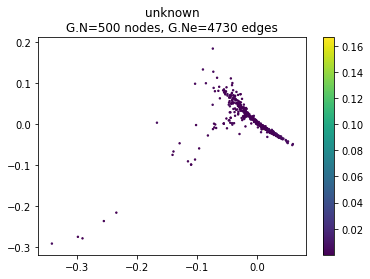

In [26]:
dirac = np.zeros(n_nodes);
dirac[nodes=='Stan Lee'] = 1;
x = graph_filter(dirac, heat_kernel, t=0.01)
G.plot_signal(x, vertex_size=2, show_edges=False)

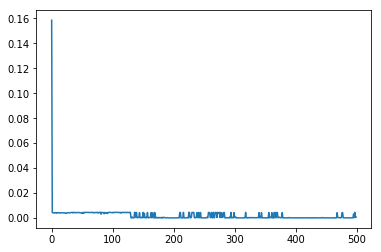

In [24]:
plt.plot(x)